# Datathon FME 2022

In [50]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

In [51]:
df_cities = pd.read_csv(r"C:\Users\Álex\Documents\Datathon\data\datathonfme2022-main\datathonfme2022-main\accenture_challenge\datathon_SC_ACN_22\cities_data.csv", sep=";", encoding="UTF-8")
df_orders = pd.read_csv(r"C:\Users\Álex\Documents\Datathon\data\datathonfme2022-main\datathonfme2022-main\accenture_challenge\datathon_SC_ACN_22\orders.csv", sep=";", encoding="UTF-8")

In [52]:
df_cities.head()

,city_from_name,city_to_name,city_from_coord,city_to_coord,distance
0,Dusseldorf,Zaragoza,"(51.2254018, 6.7763137)","(41.6521342, -0.8809428)",1214.4772
1,Dusseldorf,Venlo,"(51.2254018, 6.7763137)","(51.39244885, 6.1511724144122955)",47.3876
2,Dusseldorf,Bratislava,"(51.2254018, 6.7763137)","(48.1516988, 17.1093063)",819.2894
3,Dusseldorf,Hamburg,"(51.2254018, 6.7763137)","(53.550341, 10.000654)",339.2215
4,Dusseldorf,Rome,"(51.2254018, 6.7763137)","(41.8933203, 12.4829321)",1125.0290


In [53]:
df_orders.head()

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723,583,True
1,45f906331e10,Rotterdam,v_004,CRF,Rome,Marseille,1644308,459,False
2,ac84a6e4af0f,Athens,v_002,CRF,Venlo,Paris,1684170,464,True
3,f5e98cb29790,Rotterdam,v_004,CRF,Lille,Milan,1620510,678,False
4,a9e7c9bee35b,Barcelona,v_002,CRF,Venlo,Berlin,1699372,353,False


## Feature Engineering

In this step we added some interesting features to the dataset such as the distance or the type of material being handled

In [54]:
distances = []
for i in df_orders.values:
    dist = ((df_cities[(df_cities["city_from_name"] == i[1]) & (df_cities["city_to_name"] == i[4])]["distance"].values) or (df_cities[(df_cities["city_from_name"] == i[4]) & (df_cities["city_to_name"] == i[1])]["distance"].values))
    if (dist):
        distances.append(dist[0])
    else:
        distances.append(0)

C:\Users\Álex\AppData\Local\Temp\ipykernel_18188\886607660.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  dist = ((df_cities[(df_cities["city_from_name"] == i[1]) & (df_cities["city_to_name"] == i[4])]["distance"].values) or (df_cities[(df_cities["city_from_name"] == i[4]) & (df_cities["city_to_name"] == i[1])]["distance"].values))
C:\Users\Álex\AppData\Local\Temp\ipykernel_18188\886607660.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (dist):


In [55]:
df_orders["dist_to_hub"] = distances

In [56]:
df_orders.values[0]

array(['366c7a3d298f', 'Rotterdam', 'v_002', 'DTP', 'Venlo', 'Marseille',
       1692723, 583, True, 130.0459], dtype=object)

In [57]:
distances = []
for i in df_orders.values:
    dist = ((df_cities[(df_cities["city_from_name"] == i[4]) & (df_cities["city_to_name"] == i[5])]["distance"].values) or (df_cities[(df_cities["city_from_name"] == i[5]) & (df_cities["city_to_name"] == i[4])]["distance"].values))
    if (dist):
        distances.append(dist[0])
    else:
        distances.append(0)

C:\Users\Álex\AppData\Local\Temp\ipykernel_18188\3060743590.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  dist = ((df_cities[(df_cities["city_from_name"] == i[4]) & (df_cities["city_to_name"] == i[5])]["distance"].values) or (df_cities[(df_cities["city_from_name"] == i[5]) & (df_cities["city_to_name"] == i[4])]["distance"].values))
C:\Users\Álex\AppData\Local\Temp\ipykernel_18188\3060743590.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (dist):


In [58]:
df_orders["hub_to_custom"] = distances

In [59]:
df_orders.head()

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order,dist_to_hub,hub_to_custom
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723,583,True,130.0459,902.0420
1,45f906331e10,Rotterdam,v_004,CRF,Rome,Marseille,1644308,459,False,1269.2365,604.0216
2,ac84a6e4af0f,Athens,v_002,CRF,Venlo,Paris,1684170,464,True,2029.5726,392.9249
3,f5e98cb29790,Rotterdam,v_004,CRF,Lille,Milan,1620510,678,False,173.9644,733.8784
4,a9e7c9bee35b,Barcelona,v_002,CRF,Venlo,Berlin,1699372,353,False,1153.4178,512.8188


In [60]:
df_orders.to_csv(r"..\data\orders.csv")

### Mixing Features

In [61]:
from sklearn.linear_model import LinearRegression
df_onehot = pd.get_dummies(df_orders, prefix = ["customs_procedures", "3pl"], columns = ["customs_procedures", "3pl"])

df_onehot.head()

,order_id,origin_port,logistic_hub,customer,product_id,units,late_order,dist_to_hub,hub_to_custom,customs_procedures_CRF,customs_procedures_DTD,customs_procedures_DTP,3pl_v_001,3pl_v_002,3pl_v_003,3pl_v_004
0,366c7a3d298f,Rotterdam,Venlo,Marseille,1692723,583,True,130.0459,902.0420,0,0,1,0,1,0,0
1,45f906331e10,Rotterdam,Rome,Marseille,1644308,459,False,1269.2365,604.0216,1,0,0,0,0,0,1
2,ac84a6e4af0f,Athens,Venlo,Paris,1684170,464,True,2029.5726,392.9249,1,0,0,0,1,0,0
3,f5e98cb29790,Rotterdam,Lille,Milan,1620510,678,False,173.9644,733.8784,1,0,0,0,0,0,1
4,a9e7c9bee35b,Barcelona,Venlo,Berlin,1699372,353,False,1153.4178,512.8188,1,0,0,0,1,0,0


order_id
origin_port
logistic_hub
customer
product_id
[[0.34012546]
 [0.21055588]
 [0.21578046]
 ...
 [0.21578046]
 [0.13636684]
 [0.23458894]]
units
late_order
[[0.15384281]
 [0.27311986]
 [0.35272959]
 ...
 [0.15879126]
 [0.26057326]
 [0.15384281]]
dist_to_hub
[[0.23424661]
 [0.21573747]
 [0.20262689]
 ...
 [0.24809566]
 [0.20850641]
 [0.28209591]]
hub_to_custom
customs_procedures_CRF
customs_procedures_DTD
customs_procedures_DTP
[[0.22679423]
 [0.22679423]
 [0.22679423]
 ...
 [0.22679423]
 [0.22679423]
 [0.22679423]]
3pl_v_001
[[0.19944664]
 [0.27299078]
 [0.19944664]
 ...
 [0.19944664]
 [0.27299078]
 [0.19944664]]
3pl_v_002
[[0.23682029]
 [0.23682029]
 [0.23682029]
 ...
 [0.23682029]
 [0.25025242]
 [0.23682029]]
3pl_v_003
[[0.22534969]
 [0.25694929]
 [0.22534969]
 ...
 [0.22534969]
 [0.22534969]
 [0.22534969]]
3pl_v_004


'\nX = np.array(df_orders["hub_to_custom"]).reshape(-1, 1)\ny = df_orders["customs_procedures"]\nreg = LinearRegression().fit(X, y)\n'

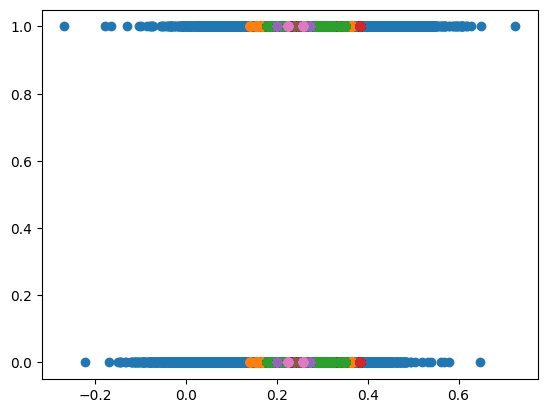

In [89]:
columnas = df_onehot.keys()

for i in columnas:
    if (i == "units" or i == "dist_to_hub" or i == "hub_to_custom"
        or i == "3pl_v_001" or i == "3pl_v_002"
        or  i == "3pl_v_003" or i == "3pl_v_004"):
        X = np.array(df_onehot[i]).reshape(-1, 1)
        y = np.array(df_onehot["late_order"]).reshape(-1, 1)
        reg = LinearRegression()
        reg.fit(X, y)
        pred = reg.predict(X)
        print(pred)
        plt.scatter(pred, y)
    print(i)
"""
X = np.array(df_orders["hub_to_custom"]).reshape(-1, 1)
y = df_orders["customs_procedures"]
reg = LinearRegression().fit(X, y)
"""

In [145]:
df_onehot.groupby("late_order")["origin_port"].count()

KeyError: 'Column not found: origin_port'

In [118]:
from sklearn.feature_selection import mutual_info_regression
#df_onehot.drop(["order_id", "origin_port", "logistic_hub", "customer", "product_id"], inplace=True, axis=1)
X = df_onehot.copy()
y = X.pop("late_order")
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

dist_to_hub               0.034615
customs_procedures_DTP    0.004293
customs_procedures_CRF    0.001358
3pl_v_004                 0.000000
Name: MI Scores, dtype: float64

In [133]:
df_onehot["latecount_v001"] = df_onehot.groupby("3pl_v_001")["late_order"].transform("count") * df_onehot["3pl_v_001"]
df_onehot["latecount_v002"] = df_onehot.groupby("3pl_v_002")["late_order"].transform("count") * df_onehot["3pl_v_002"]
df_onehot["latecount_v003"] = df_onehot.groupby("3pl_v_003")["late_order"].transform("count") * df_onehot["3pl_v_003"]
df_onehot["latecount_v004"] = df_onehot.groupby("3pl_v_004")["late_order"].transform("count") * df_onehot["3pl_v_004"]

In [135]:
df_onehot["3pl counts"] = df_onehot["latecount_v001"] + df_onehot["latecount_v002"] + df_onehot["latecount_v003"] + df_onehot["latecount_v004"]

In [172]:
df_onehot = df_onehot.drop(["latecount_v001", "latecount_v002", "latecount_v003", "latecount_v004"], axis=0)
#df_onehot = df_onehot.drop(["3pl_v_001", "3pl_v_002", "3pl_v_003", "3pl_v_004"], axis = 1)

KeyError: "['latecount_v001', 'latecount_v002', 'latecount_v003', 'latecount_v004'] not found in axis"

In [169]:
df_onehot.head()

,units,late_order,dist_to_hub,hub_to_custom,customs_procedures_CRF,customs_procedures_DTD,customs_procedures_DTP,latecount_v001,latecount_v002,latecount_v003,latecount_v004,3pl counts
0,583,True,130.0459,902.0420,0,0,1,0,54937,0,0,54937
1,459,False,1269.2365,604.0216,1,0,0,0,0,0,44429,44429
2,464,True,2029.5726,392.9249,1,0,0,0,54937,0,0,54937
3,678,False,173.9644,733.8784,1,0,0,0,0,0,44429,44429
4,353,False,1153.4178,512.8188,1,0,0,0,54937,0,0,54937


## Plottings

In [19]:
import matplotlib.pyplot as plt

In [146]:
X = df_onehot.copy()
y = X.pop("late_order")

## Machine Learning

In [153]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [154]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [157]:
y_pred = classifier.predict(X_test) 
y_pred

array([ True,  True, False, ..., False, False, False])

In [180]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import roc_curve
print ("Accuracy : ", roc_curve(y_test, y_pred))
cm

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [175]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_leaf_nodes = 100, random_state = 1)

In [176]:
model.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)

In [181]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", roc_curve(y_test, y_pred))
cm

ValueError: Classification metrics can't handle a mix of binary and continuous targets